In [1]:
import numpy as np
from scipy import interpolate
import os
import sys
import lumapi

sys.path.append('..')
from Utilities.wavelength import Wavelength
from Utilities.base_script import BaseScript
from Geometries.topology import Density2D
from Geometries.polygon import FunctionDefinedPolygon
from Figures_of_merit.modematch import ModeMatch
from Optimizers.generic_optimizers import ScipyOptimizers
from optimization import Optimization
from Utilities.simulation import Simulation

%load_ext autoreload
%autoreload 2

Use FunctionDefinedPolygon to draw the initial geometry and record it in density representation. In the end, clear unnecessary elements.

In [2]:
## Define base script ##
base_script = os.path.join(os.getcwd(), 'Y_splitter.lsf')
base_script = BaseScript(base_script)
## Define optimizable geometry ##
# We will use calss FunctionDefinedPolygon here, and the parameterized Polygon will receive 11 points of polygon's upper part (aligned in clockwise) and return 200 cubic interpolated points (aligned in counter-clockwise), making it quite smooth
num = 11

initial_points_x = np.linspace(- 1.0e-6, 1.0e-6, num)
initial_points_y = np.linspace(0.25e-6, 0.6e-6, num)
def taper_splitter(params = initial_points_y):
    """Parameters are the y coordinate of the nodes consisting the upper part of the polygon"""
    points_x = np.concatenate(([initial_points_x.min() - 0.01e-6], initial_points_x, [initial_points_x.max() + 0.01e-6]))
    points_y = np.concatenate(([initial_points_y.min()],  params, [initial_points_y.max()]))
    n_interpolation_points = 100
    polygon_points_x = np.linspace(points_x.min(), points_x.max(), n_interpolation_points)
    interpolator = interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[: : -1] + polygon_points_down)
    return polygon_points

bounds = np.array([(0.2e-6, 0.8e-6)] * num)
geometry = FunctionDefinedPolygon(func = taper_splitter, start_params = initial_points_y, bounds = bounds, dx = 1e-9, z = 0.0, depth = 220e-9, eps_in = 2.8 ** 2, eps_out = 1.44 ** 2, edge_precision = 5)

workingDir = os.getcwd()
sim = Simulation(workingDir, use_var_fdtd=False, hide_fdtd_cad=False)
base_script(sim.fdtd)
Optimization.add_index_monitor(sim, 'opt_fields')


start_params = geometry.get_current_params()
geometry.add_geo(sim, start_params, only_update=False)
sim.run('test', 0) # Run the simulation so that we can use getnamed
geometry.get_eps_from_index_monitor(sim.fdtd, 'eps', 'opt_fields')
epsilon = lumapi.getVar(sim.fdtd.handle, 'eps')
initial_eps = np.real(epsilon[:,:,0,0,0])
x = sim.fdtd.getresult('opt_fields_index', 'x')
x = x.reshape(-1) # Be aware that the original x shape in a 2D array
y = sim.fdtd.getresult('opt_fields_index', 'y')
y = y.reshape(-1)
# x_start = sim.fdtd.getnamed('opt_fields_index', 'x min')
# x_end = sim.fdtd.getnamed('opt_fields_index', 'x max')
# y_start = sim.fdtd.getnamed('opt_fields_index', 'y min')
# y_end = sim.fdtd.getnamed('opt_fields_index', 'y max')
x_num = initial_eps.shape[0]
y_num =initial_eps.shape[1]

del sim, num, initial_points_x, initial_points_y, bounds, geometry, workingDir, start_params

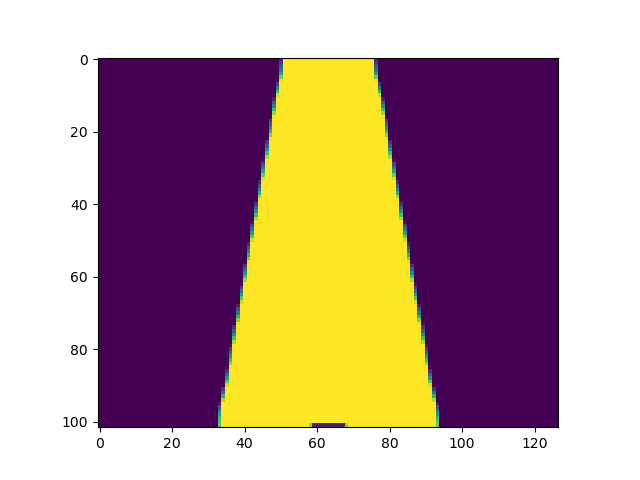

In [3]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.imshow(initial_eps)

In [4]:
z = np.array([-110e-9, 110e-9])
geometry = Density2D(eps = initial_eps, x = x, y = y, z = z, eps_min = 1.44**2, eps_max = 2.8**2)
## Define spectral range ##
wavelengths = Wavelength(start = 1300e-9, stop = 1800e-9, points = 21)
## Define figure of merit ##
fom = ModeMatch(monitor_name = 'fom', mode_num = 2, direction = 'Forward', mul_freq_src = True, target_T_foward = lambda wl: np.ones(wl.size), norm_p = 1)

## Define the optimization algorithm ##
# This will run Scipy's implementation pf the L-BFGS-B algorithm for at most 30 iteration. Since the variable are on the order of 1e-6, they are scale up to be on the order of 1.
optimizer = ScipyOptimizers(max_iter = 30, method = 'L-BFGS-B', scaling_factor = 1, pgtol = 1e-100, ftol=1e-100)

## Put everything together
# We will test the dir_grad == True and dir_grad == False two cases with the direct differentiation method
#opt1 = Optimization(base_script = base_script, wavelength = wavelengths, fom = fom, geometry = geometry, optimizer = optimizer, hide_fdtd_cad = False, dir_grad = True)
opt2 = Optimization(base_script = base_script, wavelength = wavelengths, fom = fom, geometry = geometry, optimizer = optimizer, hide_fdtd_cad = False, dir_grad = False)

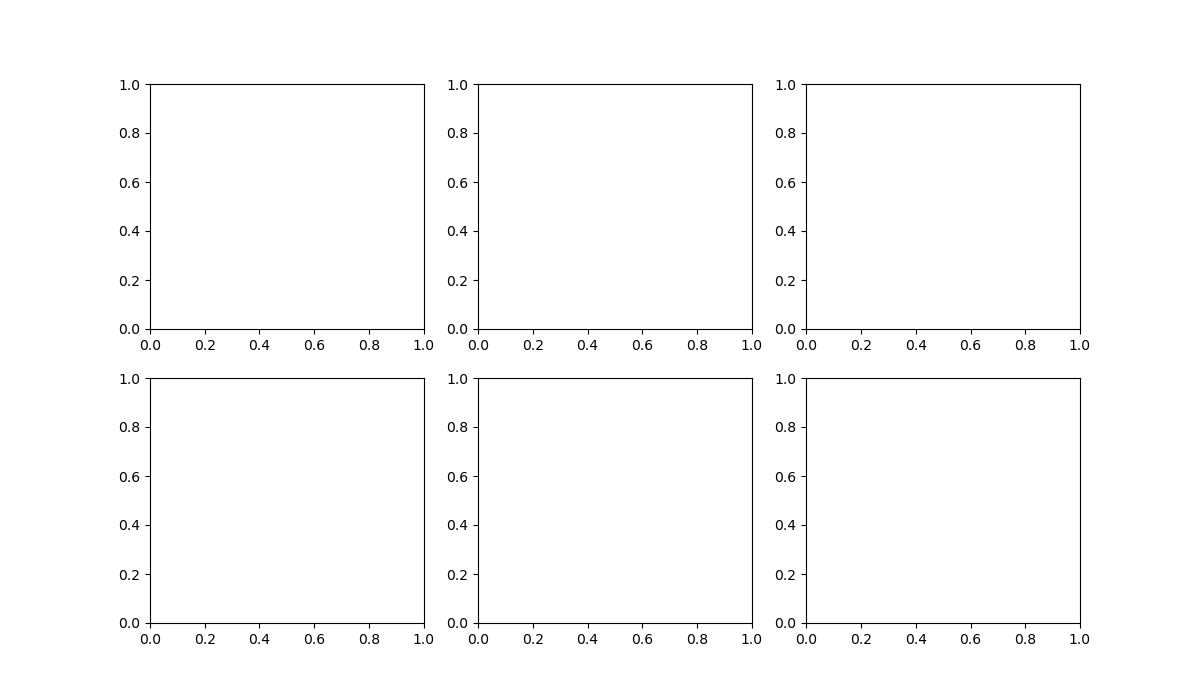

Run the scipy optimization 

Bounds = [[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]] 

Start = [0. 0. 0. ... 0. 0. 0.] 

Running forward simulation
FOM = 0.7266953656499116
Running adjoint simulation
Calculating gradients
Running forward simulation
FOM = 0.3364230169991863
Running adjoint simulation
Calculating gradients
Running forward simulation
FOM = 0.7266953995139478
Running adjoint simulation
Calculating gradients
Running forward simulation
FOM = 0.8745905220681793
Running adjoint simulation
Calculating gradients
Plots updated with iteration 0 result
Running forward simulation
FOM = 0.9471703187883933
Running adjoint simulation
Calculating gradients
Plots updated with iteration 1 result
Running forward simulation
FOM = 0.963876952795034
Running adjoint simulation
Calculating gradients
Plots updated with iteration 2 result
Running forward simulation
FOM = 0.977985186177275
Running adjoint simulation
Calculating gradients
Plots updated with iteration 3 result
Running forward simul

(0.9986763228761023,
 array([0.00308049, 0.00308344, 0.00338261, ..., 0.        , 0.        ,
        0.        ]))

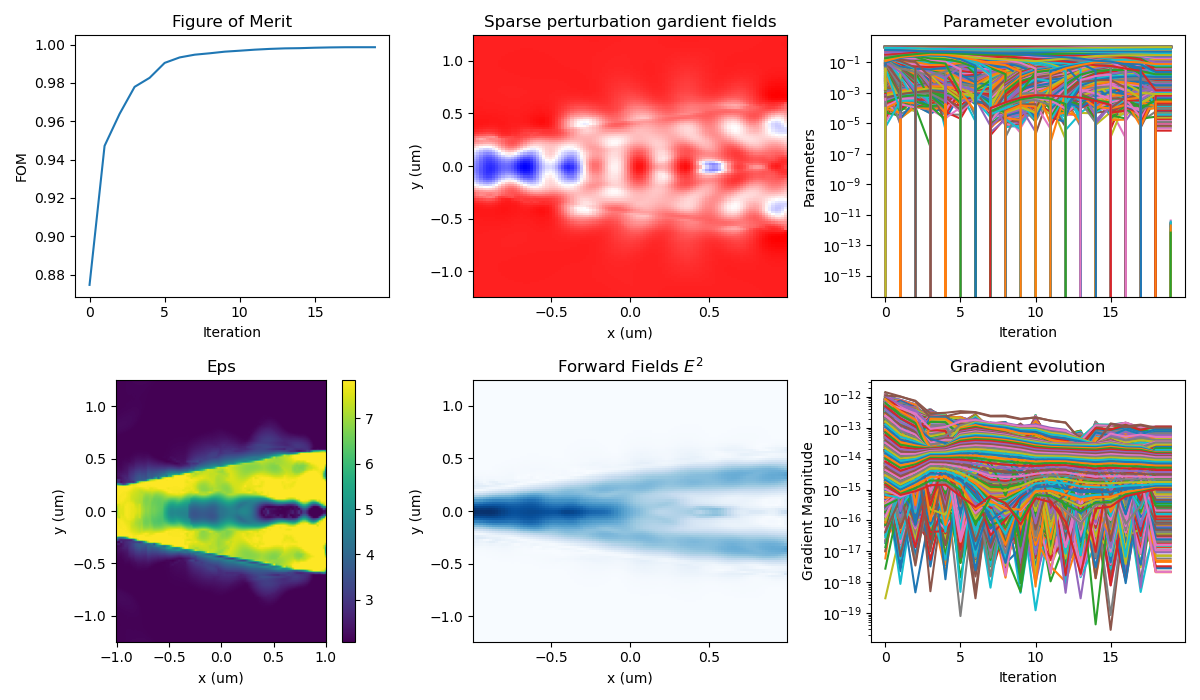

In [5]:
opt2.run()

In [7]:
a = np.array([1,1,1,1,1,1,1,1])
np.reshape(a, (a.size,-1))

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])